In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsbombpy import sb
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mplsoccer import Pitch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

## Introdução

Este trabalho tem como objetivo aplicar técnicas de análise de dados futebolísticos a partir de eventos e dados 360, explorando o potencial dos dados da StatsBomb e da camada 360º. Através de métricas taticamente relevantes, pretende-se observar comportamentos individuais e coletivos.

Os dados utilizados provêm da plataforma StatsBomb, incluindo:
- **Eventos**: ações como passes, remates, pressões, interceções, entre outros, com elevada granularidade.
- **Dados 360º**: capturas do contexto posicional no momento dos eventos, permitindo análises sobre ângulos de passe, linhas de pressão e disponibilidade dos colegas de equipa.

Após a definição e cálculo das métricas avançadas o passo seguinte consiste na criação de **perfis de jogadores** com base no seu desempenho ao longo de **múltiplos jogos**. O objetivo é identificar **semelhanças táticas** e **diferenciação entre papéis desempenhados** em campo.

Para definir e comparar os perfis de jogadores, serão aplicadas **abordagens quantitativas** baseadas em princípios de estatística e machine learning. Estas metodologias permitem identificar padrões de semelhança entre jogadores e avaliar a qualidade da segmentação gerada.

## Obtenção e Preparação dos Dados (ETL)

In [2]:
def get_competition_info(competition_name, season_name):
    
    # Carrega o DataFrame com todas as competições disponíveis
    comps_df = sb.competitions()

    # Verifica se as colunas necessárias existem no DataFrame
    if "competition_name" in comps_df.columns and "season_name" in comps_df.columns:
        # Filtra pelas competições cujo nome e época correspondem aos parâmetros fornecidos
        competition_info = comps_df[
            comps_df["competition_name"].str.contains(competition_name, case=False, na=False) &
            comps_df["season_name"].str.contains(season_name, na=False)
        ]
        return competition_info

    # Caso não existam as colunas esperadas, retorna um DataFrame vazio
    return pd.DataFrame()


In [3]:
# Obtemos os identificadores do Euro 2024, necessários para aceder aos dados dos jogos via API da StatsBomb
info = get_competition_info("UEFA Euro", "2024")
info

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500


In [4]:
euro_2024_matches = sb.matches(competition_id=info['competition_id'].iloc[0], season_id=info['season_id'].iloc[0])

chosen_match = euro_2024_matches[euro_2024_matches['match_id'] == 3930180]
chosen_match

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
5,3930180,2024-06-25,19:00:00.000,Europe - UEFA Euro,2024,Netherlands,Austria,2,3,available,...,2024-07-11T13:25:37.289456,3,Group Stage,Olympiastadion Berlin,Ivan Kružliak,Ronald Koeman,Ralf Rangnick,1.1.0,2,2


In [5]:
# Carregamos todos os jogos do Euro 2024 e filtramos o DataFrame para manter apenas o jogo entre Turquia e Geórgia
euro_2024_matches = sb.matches(competition_id=info['competition_id'].iloc[0], season_id=info['season_id'].iloc[0])

chosen_match = euro_2024_matches[euro_2024_matches['match_id'] == 3938639]
chosen_match

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
32,3938639,2024-06-18,19:00:00.000,Europe - UEFA Euro,2024,Turkey,Georgia,3,1,available,...,2024-07-12T06:05:10.871017,1,Group Stage,Signal-Iduna-Park,Facundo Tello Figueroa,Vincenzo Montella,Willy Sagnol,1.1.0,2,2


In [6]:
# Obter os plantéis de ambas as equipas
lineups = sb.lineups(match_id=chosen_match['match_id'].iloc[0])

def lineups_to_dataframe(lineups):

    all_players = []

    for team, team_df in lineups.items():
        # Copiar DataFrame da equipa para evitar alterações ao original
        temp_df = team_df.copy()

        # Expandir a primeira posição da lista de 'positions' para uma coluna de dicionário
        temp_df["position_dict"] = temp_df["positions"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

        # Expandir o dicionário da posição para colunas separadas
        position_expanded = temp_df["position_dict"].apply(pd.Series)
        position_expanded = position_expanded.rename(columns=lambda col: f"position_{col}")

        # Expandir a primeira entrada dos cartões, se existirem
        temp_df["card_dict"] = temp_df["cards"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

        # Expandir o dicionário dos cartões em colunas
        card_expanded = temp_df["card_dict"].apply(pd.Series)
        card_expanded = card_expanded.rename(columns=lambda col: f"card_{col}")

        # Concatenar todas as colunas relevantes
        temp_df = pd.concat([
            temp_df.drop(columns=["positions", "position_dict", "cards", "card_dict"]),
            position_expanded,
            card_expanded
        ], axis=1)

        # Adicionar DataFrame da equipa à lista
        all_players.append(temp_df)

    # Concatenar todas as equipas num único DataFrame
    lineups_df = pd.concat(all_players, ignore_index=True)

    return lineups_df


# Aplicar a função aos lineups do jogo
lineups_df = lineups_to_dataframe(lineups)
lineups_df



,player_id,player_name,player_nickname,jersey_number,country,position_position_id,position_position,position_from,position_to,position_from_period,position_to_period,position_start_reason,position_end_reason,card_time,card_card_type,card_reason,card_period
0,3648,Cenk Tosun,None,9,Turkey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7039,Hakan Çalhanoğlu,None,10,Turkey,9.0,Right Defensive Midfield,00:00,45:00,1.0,2.0,Starting XI,Tactical Shift,88:04,Yellow Card,Foul Committed,2.0
2,9085,Salih Özcan,None,15,Turkey,11.0,Left Defensive Midfield,90:30,91:15,2.0,2.0,Substitution - On (Tactical),Tactical Shift,NaN,NaN,NaN,NaN
3,10349,Mehmet Zeki Çelik,Zeki Celik,2,Turkey,7.0,Right Wing Back,85:12,None,2.0,NaN,Substitution - On (Injury),Final Whistle,NaN,NaN,NaN,NaN
4,10826,Mert Müldür,None,18,Turkey,2.0,Right Back,00:00,76:07,1.0,2.0,Starting XI,Player Off,NaN,NaN,NaN,NaN
5,12293,Kaan Ayhan,None,22,Turkey,11.0,Left Defensive Midfield,00:00,45:00,1.0,2.0,Starting XI,Tactical Shift,NaN,NaN,NaN,NaN
6,12555,Okay Yokuşlu,None,5,Turkey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,18723,Yunus Akgün,None,25,Turkey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,22212,Orkun Kökçü,None,6,Turkey,19.0,Center Attacking Midfield,00:00,78:38,1.0,2.0,Starting XI,Tactical Shift,NaN,NaN,NaN,NaN
9,23558,Merih Demiral,None,3,Turkey,9.0,Right Defensive Midfield,78:31,78:38,2.0,2.0,Substitution - On (Tactical),Tactical Shift,NaN,NaN,NaN,NaN


In [7]:
# Carregamos os dados de eventos e os dados 360º para o jogo selecionado 
events = sb.events(match_id=3938639)
events_360 = sb.frames(match_id=3938639)

# Realizamos o merge dos eventos com os dados 360º através do id do evento
match_events = events.merge(events_360, on="id", how="left")
match_events

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,team_id,timestamp,type,under_pressure,visible_area,match_id_y,teammate,actor,keeper,location_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,909,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,909,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,909,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:51:22.233,Error,NaN,"[91.25474482352054, 80.0, 73.54094854184356, 1...",3938639.0,True,False,False,"[109.35785693257753, 40.23147058410604]"
55472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:51:22.233,Error,NaN,"[91.25474482352054, 80.0, 73.54094854184356, 1...",3938639.0,True,False,False,"[109.91997613118804, 32.19691924449425]"
55473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:51:22.233,Error,NaN,"[91.25474482352054, 80.0, 73.54094854184356, 1...",3938639.0,False,False,False,"[109.93911979733062, 39.161447821469636]"
55474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2138,00:51:22.233,Error,NaN,"[91.25474482352054, 80.0, 73.54094854184356, 1...",3938639.0,False,False,False,"[114.45809631282285, 36.738096421017566]"


## Justificação da Escolha do Jogo: Turquia vs Geórgia (UEFA Euro 2024)

A escolha do jogo *Turquia vs Geórgia*, disputado no âmbito do Euro 2024, baseia-se em dois critérios: **diversidade de contextos táticos** e **potencial analítico**.

Este jogo apresenta uma distribuição equilibrada de ações defensivas e ofensivas em diferentes zonas do terreno, com envolvimento significativo de jogadores de vários perfis e posições. Tal diversidade permite observar comportamentos táticos variados e aplicar métricas avançadas de forma representativa e comparável.

Adicionalmente, tratou-se de um dos jogos mais disputados da fase de grupos, com **elevada densidade de ações relevantes** — incluindo pressões, recuperações e movimentações ofensivas — o que enriquece a amostra de eventos e permite caracterizar jogadores com perfis táticos distintos.

Assim, o jogo *Turquia vs Geórgia* constitui uma base sólida para a aplicação de métricas avançadas que analisam o impacto dos jogadores em diferentes contextos defensivos e ofensivos.


## Raciocínio para a Escolha das Métricas

A definição de métricas neste trabalho procurou garantir relevância tática e complementaridade entre dimensões distintas do jogo. O objetivo foi selecionar indicadores que permitissem observar comportamentos significativos dos jogadores em momentos críticos, tanto com bola como sem bola.

Foi também importante garantir que pelo menos uma das métricas explorasse o potencial dos dados 360º, acrescentando contexto espacial à análise. A escolha final recaiu sobre duas métricas que, em conjunto, caracterizam de forma equilibrada a intensidade defensiva e a tomada de decisão em posse em função da proximidade de colegas: *Pressures Leading to Recovery* e *Linhas de Passe na Construção de Jogo*. 

Com esta combinação, procura-se também compreender o grau de envolvimento e proatividade dos jogadores, tanto na reação à perda da posse como na sua participação nas dinâmicas coletivas com bola.

Para além da sua utilidade analítica isolada, estas métricas fornecem uma base sólida para a criação de perfis táticos de jogadores, permitindo segmentar diferentes estilos e funções com base em comportamentos observáveis e mensuráveis.

## 1. Pressures Leading to Recovery (PLR)

**Descrição**  
A métrica *Pressures Leading to Recovery* mede a proporção de pressões realizadas por um jogador que resultam numa recuperação da posse de bola pela sua equipa nos 5 segundos seguintes. Esta abordagem permite distinguir jogadores cuja ação defensiva contribui diretamente para o sucesso coletivo na recuperação da bola.

**Justificação Tática**  
Esta métrica está alinhada com conceitos modernos de pressão coordenada e reação à perda e destaca jogadores com impacto defensivo real e não apenas volume de ações. Ao considerar o resultado da pressão, introduz uma dimensão qualitativa ausente noutras métricas.

**Cálculo**  
Para cada evento do tipo `"Pressure"`:
1. Regista-se o timestamp e equipa do jogador.
2. Procura-se, nos 5 segundos seguintes, eventos como `"Ball Recovery"`, `"Interception"` ou `"Duel"` bem-sucedidos pela mesma equipa.
3. Apenas recuperações com sucesso validado (ex.: sem `recovery_failure`) são contabilizadas.

A métrica é calculada como:

$$
PLR_j = \frac{\text{Nº de pressões com recuperação da posse em até 5 segundos}}{\text{Total de pressões realizadas por } j}
$$

**Exemplo**  
Se um jogador pressionou 20 vezes e a sua equipa recuperou a bola em 10 dessas situações nos 5 segundos seguintes:

$$
PLR = \frac{10}{20} = 0{,}50
$$

**Nota**  
Embora útil, esta métrica depende da definição de uma janela temporal e não captura recuperações taticamente induzidas fora desse intervalo. Ainda assim, fornece uma leitura sólida da eficácia da pressão.


---

## 2. Linhas de Passe na Construção de Jogo

**Descrição**  
A métrica *Linhas de Passe na Construção de Jogo* quantifica com que frequência um jogador se disponibiliza como opção de passe viável ao portador da bola durante ações de condução (`Carry`). Com recurso aos dados 360º da StatsBomb, avalia-se se o jogador sem bola está posicionado dentro de uma zona relevante (cone de 120° com raio ajustado), e sem risco de interceção por adversários, refletindo assim o seu contributo para o apoio ao progresso da jogada. Nesta análise, os centrais e guarda-redes são excluídos, uma vez que, por natureza das suas posições, tendem a surgir frequentemente desmarcados em zonas recuadas, o que poderia enviesar a métrica a seu favor sem refletir um verdadeiro envolvimento ofensivo ou intenção de progressão no jogo.

**Justificação Tática**  
Na fase de construção, a criação de linhas de passe é essencial para garantir fluidez ofensiva, atrair marcações e permitir saídas limpas sob pressão. Esta métrica distingue jogadores com boa leitura posicional e capacidade de apoio dinâmico, avaliando não só a proximidade, mas a relevância do posicionamento face ao contexto do portador da bola.

**Cálculo**  
Para cada evento `"Carry"` com dados `freeze_frame` disponíveis:

1. Obtém-se a direção do movimento do portador da bola.
2. Para cada jogador da mesma equipa (`teammate = True`), avalia-se:
   - Se está posicionado dentro de um **cone de 120°**, centrado na direção do *carry*;
   - Se se encontra a uma distância igual ou inferior a:
     - **35 metros** nos dois primeiros terços do campo;
     - **25 metros** no último terço ofensivo (x ≥ 80 no sistema StatsBomb);
   - Se **nenhum adversário visível bloqueia a linha de passe direta**, considerando uma zona de influência defensiva de ~2 metros.
3. O jogador é considerado uma **opção de passe válida** se cumprir todos os critérios acima.

A métrica por jogador é então calculada como:

$$
\text{Disponibilidade}_j = \frac{\text{Nº de vezes que } j \text{ foi opção válida}}{\text{Nº total de vezes que apareceu visível em carries}}
$$

**Exemplo**  
Se um jogador aparece em 60 eventos com `freeze_frame`, e em 15 desses foi considerado uma opção de passe válida:

$$
\text{Disponibilidade} = \frac{15}{60} = 0{,25}
$$

**Nota:**  
Apesar de oferecer uma leitura rica sobre envolvimento ofensivo, esta métrica tem algumas limitações:

- Baseia-se apenas nos eventos de *carry* com dados 360º disponíveis, não capturando contextos onde não há condução.
- Assume que a linha de passe é reta e instantânea, não considerando obstáculos dinâmicos nem movimentos subsequentes dos adversários.
- A visibilidade dos jogadores depende do `freeze_frame`, o que pode omitir alguns posicionamentos válidos fora do campo de visão da câmara.
- Pode favorecer jogadores que jogam mais recuados (com menos pressão) — daí a necessidade de filtrar posições defensivas em análises focadas em criação ofensiva.

## 1. Pressures Leading to Recovery (PLR)

In [8]:
# Define os tipos de eventos que podem ser considerados como recuperação da posse
RECOVERY_EVENTS = [
    "Ball Recovery", "Interception", "Pass", "Carry", "Dribble", "Shot", "Ball Receipt*", "Foul Won", "Duel"
]

def plr(events_df):
    # Garante que a coluna 'timestamp' está no formato datetime para comparação temporal
    events_df = events_df.copy()
    if not pd.api.types.is_timedelta64_dtype(events_df["timestamp"]):
        events_df["timestamp"] = pd.to_timedelta(events_df["timestamp"])

    # Filtra apenas os eventos do tipo "Pressure"
    pressures = events_df[events_df["type"] == "Pressure"].copy()
    pressures["recovery_in_5s"] = False  # Coluna que irá indicar se houve recuperação após a pressão

    # Itera sobre cada evento de pressão
    for idx, row in pressures.iterrows():
        pressure_time = row["timestamp"]
        team_id = row["team_id"]

        # Seleciona os eventos que ocorrem até 5 segundos após a pressão
        window = events_df[
            (events_df["timestamp"] > pressure_time) &
            (events_df["timestamp"] <= pressure_time + timedelta(seconds=5))
        ]

        # Filtra eventos da mesma equipa e que sejam tipos considerados de recuperação
        recovered = window[
            (window["team_id"] == team_id) &
            (window["type"].isin(RECOVERY_EVENTS))
        ]

        valid_recovery = False  # Flag que será usada para indicar se houve recuperação válida

        # Verifica se algum dos eventos no intervalo pode ser considerado recuperação válida
        for _, rec in recovered.iterrows():
            event_type = rec["type"]

            if event_type == "Interception":
                # Só conta se o desfecho da interceção não for negativo
                if rec.get("interception_outcome") not in ["Lost Out", "Lost In Play", None]:
                    valid_recovery = True

            elif event_type == "Ball Recovery":
                # Só conta se não tiver falhado a recuperação
                if not rec.get("ball_recovery_recovery_failure", False):
                    valid_recovery = True

            elif event_type == "Duel":
                # Só conta se o duelo não for aéreo perdido nem tiver um desfecho negativo
                if (
                    rec.get("duel_type") != "Aerial Lost" and
                    rec.get("duel_outcome") not in ["Lost", "Lost In Play", "Lost Out"]
                ):
                    valid_recovery = True

            else:
                # Outros eventos (como Pass, Carry, etc.) contam diretamente
                valid_recovery = True

            if valid_recovery:
                pressures.at[idx, "recovery_in_5s"] = True  # Marca que a pressão levou a recuperação
                break  # Para a iteração assim que encontra uma recuperação válida

    # Agrupa os eventos de pressão por jogador
    plr_by_player = pressures.groupby("player_id")["recovery_in_5s"].agg(
        total_recoveries="sum",
        total_pressures="count",
        PLR="mean") 

    # Calcula o PLR por equipa
    plr_by_team = pressures.groupby("team_id")["recovery_in_5s"].agg(
        total_recoveries="sum",
        total_pressures="count",
        team_PLR="mean")   
    
    # Adicionar coluna com o nome da equipa
    plr_by_team['team'] = pressures.groupby("team_id")["team"].first()


    return plr_by_player, plr_by_team

In [9]:
player_plr_df, team_plr_df = plr(events)

# Adiciona os nomes dos jogadores ao DataFrame de PLR dos jogadores
players_pr = lineups_df.merge(player_plr_df, left_on="player_id", right_index=True, how="left")

# Remover jogadores que não pressionaram
players_pr = players_pr.dropna(subset=["PLR"])

# Ordenar os jogadores pelo PLR
players_pr.sort_values(by="PLR", ascending=False, inplace=True)

# Selecionar colunas relevantes para o DataFrame final
players_pr = players_pr[[
    "player_id", 
    "player_name", 
    "country", 
    "position_position", 
    "total_recoveries", 
    "total_pressures", 
    "PLR"
]]

print("\nTeam PLR Statistics:")
print(team_plr_df)

# Exportar Dataset
players_pr.to_csv("players_plr.csv", index=False)
players_pr


Team PLR Statistics:
         total_recoveries  total_pressures  team_PLR     team
team_id                                                      
909                    50               89  0.561798   Turkey
2138                   72              136  0.529412  Georgia


,player_id,player_name,country,position_position,total_recoveries,total_pressures,PLR
43,102372,Budu Zivzivadze,Georgia,Right Center Back,2.0,2.0,1.000000
5,12293,Kaan Ayhan,Turkey,Left Defensive Midfield,5.0,5.0,1.000000
10,29989,Yusuf Yazıcı,Turkey,Center Forward,2.0,2.0,1.000000
17,49689,Muhammed Kerem Aktürkoğlu,Turkey,Left Wing,2.0,2.0,1.000000
19,116587,Arda Güler,Turkey,Right Wing,6.0,7.0,0.857143
24,151813,Kenan Yildiz,Turkey,Left Wing,5.0,6.0,0.833333
39,44183,Zuriko Davitashvili,Georgia,Right Wing,4.0,5.0,0.800000
22,134209,Barış Alper Yılmaz,Turkey,Center Forward,7.0,10.0,0.700000
41,48178,Luka Lochoshvili,Georgia,Left Wing Back,2.0,3.0,0.666667
27,7839,Guram Kashia,Georgia,Center Back,4.0,6.0,0.666667


Apesar da **Geórgia** ter sido a equipa que mais pressionou durante o jogo, os valores de **PLR** revelam que a **Turquia apresentou maior eficácia na recuperação imediata da posse** (`PLR médio`: **Turquia 0.561** vs **Geórgia 0.529**). Este contraste sugere que, embora os georgianos tenham pressionado mais vezes, os turcos conseguiram fazê-lo de forma mais coordenada e eficiente.

No setor ofensivo, os avançados turcos destacaram-se por **valores de PLR muito elevados**, apesar de realizarem menos ações de pressão do que adversários.  
Jogadores como *Arda Güler* (PLR: 0.86), *Yilmaz* (0.7) e *Kenan Yildiz* (0.83)  demonstraram uma elevada capacidade de recuperar a posse com poucas ações, o que reforça a ideia de uma **pressão alta coordenada**, aplicada no momento certo e com elevada eficácia coletiva. Todos estes jogadores tiveram um número semelhante de pressões o que reforça ainda mais essa ideia.

A Geórgia também contou com avançados ativos na pressão, nomeadamente *Georges Mikautadze*, um dos jogadores com maior volume de ações pressionantes e com um **PLR bastante elevado (0.65)** para o número de pressões realizadas.  
Ainda assim, a **eficácia média dos avançados georgianos foi inferior** à dos turcos, o que pode indiciar menor coordenação coletiva ou menor sucesso na execução da pressão em zonas adiantadas com *Kvaratskhelia* a apresentar um PLR de 0.4.

No centro do terreno, a **Geórgia continua a ser a equipa com maior atividade pressionante**, com jogadores como *Anzor Mekvabishvili* a destacar-se com PLR de 0.59 enquanto os restantes médios, embora mais pressionantes, não apresentaram uma pressão tão eficaz.  
Este padrão contrasta com o comportamento dos médios turcos, que pressionou menos, mas novamente de forma mais eficaz com destaque para Kaan Ayhan que apresentou um PLR de 1.0 e *Orkun Kökçü* que registou **dificuldades em traduzir a pressão em recuperações eficazes**, apresentando valores de PLR mais baixos.

Este cenário pode ser explicado em parte pelo contexto do jogo — a **Geórgia esteve mais tempo em desvantagem** e viu-se obrigada a pressionar com maior frequência, sobretudo em zonas médias e baixas.  
Tal comportamento sugere uma **abordagem mais reativa**, em que a equipa foi forçada a assumir mais riscos e procurar ativamente recuperar a posse para lançar ataques, como resposta à necessidade de inverter o resultado.

## 2. Linhas de Passe na Construção de Jogo

Por se tratar de uma métrica taticamente densa e com várias condicionantes espaciais, decidi ilustrá-la com um exemplo prático retirado do jogo entre a Turquia e a Geórgia, analisando uma situação concreta de condução de bola e as opções de passe disponíveis.

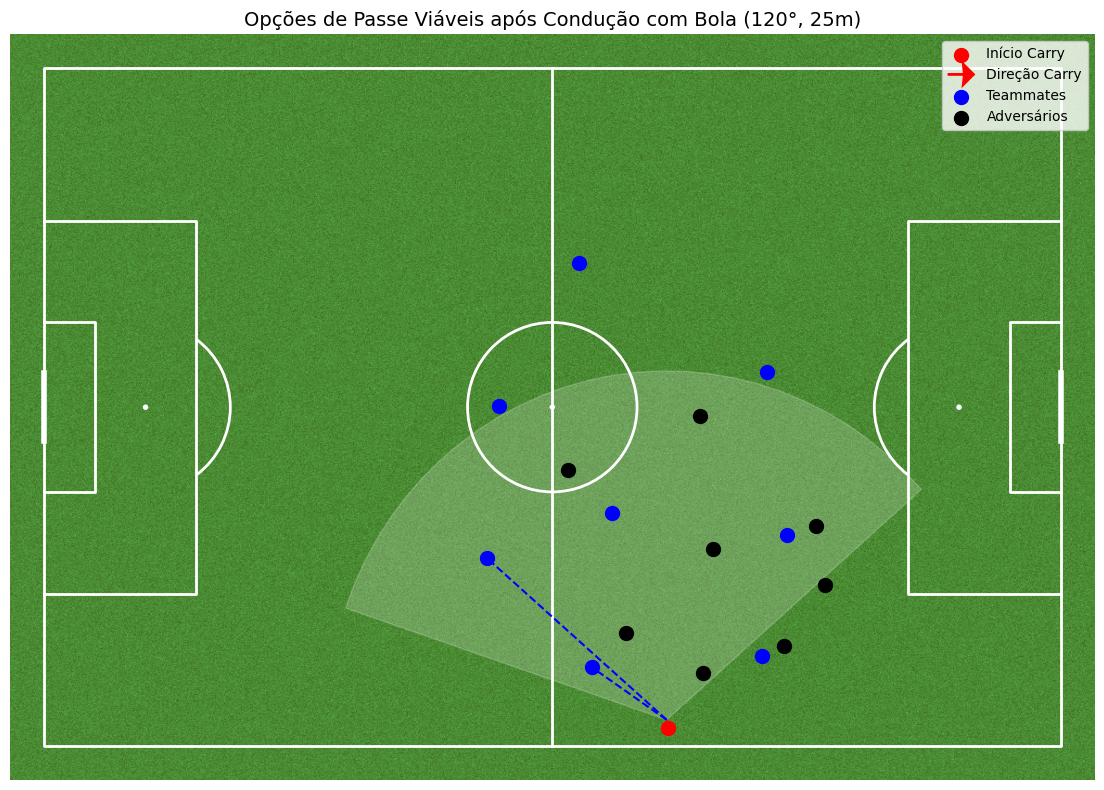

In [10]:
# Selecionar o evento de carry a analisar
carry_id = "91412c9b-4f06-4667-b64d-0c6027529a41"
carry_event = match_events[match_events["id"] == carry_id]

# Identificar Ator e calcular a posição inicial e final do carry
actor_row = carry_event[carry_event["actor"]].iloc[0]
actor_pos = np.array(actor_row["location_y"])
actor_end = np.array(actor_row["carry_end_location"])

# Calcular o vetor de carry e o ângulo (direção)
carry_vector = actor_end - actor_pos
carry_angle = np.arctan2(carry_vector[1], carry_vector[0])

# Definir zona de passe (cone elíptico de 120° até 25m reais)
scale_x, scale_y = 120 / 105, 80 / 68  # Escala para o tamanho do campo StatsBomb e com base nas medidas da FIFA
angle_tolerance = np.radians(60)  # 60° de cada lado do vetor de carry

# Ajustar o raio da zona de passe dependendo da zona do campo
radius_m = 25 if actor_end[0] >= 80 else 35

# Converte os raios de metros reais para coordenadas StatsBomb
radius_x = radius_m * scale_x
radius_y = radius_m * scale_y

# Separar teammates e adversários
teammates, opponents = [], []
for _, row in carry_event.iterrows():
    if not row["actor"]:
        player = {"player_id": row["player_id"], "position": np.array(row["location_y"])}
        (teammates if row["teammate"] else opponents).append(player)

# Verifica se um jogador está dentro do campo de visão
def is_inside_elliptical_cone(player_pos, actor_end, carry_angle):

    # Ajustar o raio da zona de passe dependendo da zona do campo (25m no último terço, 35m nos dois primeiros terços)
    radius_m = 25 if actor_end[0] >= 80 else 35

    # Converte os raios de metros reais para coordenadas StatsBomb
    radius_x = radius_m * scale_x
    radius_y = radius_m * scale_y

    # Vetor do final da condução até à posição do jogador
    vector = player_pos - actor_end

    # Ângulo absoluto do vetor em relação ao eixo horizontal
    angle = np.arctan2(vector[1], vector[0]) 

    # Diferença angular entre a direção do jogador e a direção do carry
    angle_diff = np.arctan2(np.sin(angle - carry_angle), np.cos(angle - carry_angle)) 

    # Verifica se o jogador está dentro do cone de 120°
    if abs(angle_diff) > angle_tolerance:
        return False
    
    # Normaliza as componentes do vetor com os raios da elipse
    dx = vector[0] / radius_x
    dy = vector[1] / radius_y

    # Verifica se o ponto está dentro da elipse
    return dx**2 + dy**2 <= 1  

# Verifica se a linha de passe está bloqueada por um adversário
def is_pass_blocked(start, end, defender, radius=2.3): # radius = 2.3 corresponde a um raio de tolerância à volta da linha de passe de 2 metros
    # Vetor da linha de passe
    vec = end - start

    # Caso o vetor seja nulo, não há passe possível
    if np.linalg.norm(vec) == 0:
        return False

    # Vetor unitário da linha de passe
    unit = vec / np.linalg.norm(vec)

    # Vetor entre o início do passe e o defesa 
    proj = np.dot(defender - start, unit)  # Projeção do defesa na direção da linha de passe

    # Se a projeção estiver fora da linha de passe, não pode haver bloqueio
    if proj < 0 or proj > np.linalg.norm(vec):
        return False

    # Ponto mais próximo da linha de passe à posição do defesa
    closest = start + proj * unit

    # Verifica se o defesa está suficientemente perto da linha de passe para a bloquear
    return np.linalg.norm(defender - closest) < radius

# Identificar passes válidos
valid_passes = []
for tm in teammates:
    # Primeiro verificar se o jogador está dentro do cone elíptico e depois ver se o passe não está bloqueado
    if is_inside_elliptical_cone(tm["position"], actor_end, carry_angle) and not any(
        is_pass_blocked(actor_end, tm["position"], opp["position"]) for opp in opponents
    ):
        valid_passes.append(tm)

# Desenhar campo
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

# Cone elíptico
angles = np.linspace(carry_angle - angle_tolerance, carry_angle + angle_tolerance, 30)
arc = [actor_end + np.array([radius_x * np.cos(a), radius_y * np.sin(a)]) for a in angles]
cone = Polygon([actor_end] + arc, closed=True, color='white', alpha=0.2)
ax.add_patch(cone)

# Jogadores e vetores
pitch.scatter(*actor_pos, ax=ax, color='red', s=100, label="Início Carry")
pitch.arrows(actor_pos[0], actor_pos[1], actor_end[0], actor_end[1], ax=ax, color='red', width=2, headwidth=10, label="Direção Carry", zorder=5)

# Teammates e adversários
pitch.scatter([p["position"][0] for p in teammates], [p["position"][1] for p in teammates], ax=ax, color='blue', s=100, label="Teammates")
pitch.scatter([p["position"][0] for p in opponents], [p["position"][1] for p in opponents], ax=ax, color='black', s=100, label="Adversários")

# Passes válidos
for p in valid_passes:
    ax.plot([actor_end[0], p["position"][0]], [actor_end[1], p["position"][1]], color='blue', linestyle='--', linewidth=1.5)

ax.legend()
plt.title("Opções de Passe Viáveis após Condução com Bola (120°, 25m)", fontsize=14)
plt.show()



A imagem acima ilustra a métrica de *Linhas de Passe na Construção de Jogo*. O ponto vermelho representa o início de uma condução de bola (carry), com a seta a indicar a sua direção (Neste caso o 'Carry' foi curto por isso é que nem se repara na seta). A área esbatida define a zona viável de passe: um cone de 120° com raio até 25 metros reais, centrado na direção da condução.

Os círculos azuis representam os colegas de equipa visíveis no momento, e os pretos os adversários. Apenas os jogadores posicionados dentro desta zona e que não têm a linha de passe bloqueada por adversários são considerados opções válidas. Estes estão ligados ao portador da bola com linhas tracejadas azuis.

A métrica avalia, para cada jogador, com que frequência surge como uma opção de passe válida durante conduções, refletindo a sua disponibilidade e envolvimento nas ações ofensivas da equipa.

In [11]:
def passing_lane_metric(match_events):
    results = []  # Armazena os resultados por cada carry
    player_counts = {}  # Armazena o nº de vezes que cada jogador estava no campo de visão e o nº passes válidos
    valid_pass_positions = []  # Armazena dados dos passes válidos por carry

    # Iterar sobre todos os carries únicos
    for carry_id in match_events[match_events['type'] == 'Carry']['id'].unique():
        carry_event = match_events[match_events['id'] == carry_id]
        actor_rows = carry_event[carry_event['actor'] == True]

        if actor_rows.empty:
            continue  # Ignorar se não houver actor 

        
        # Identificar actor e posição e calcular vetor e ângulo do carry
        actor_row = actor_rows.iloc[0]
        actor_pos = np.array(actor_row["location_y"])
        actor_end = np.array(actor_row["carry_end_location"])
        carry_vector = actor_end - actor_pos
        carry_angle = np.arctan2(carry_vector[1], carry_vector[0])
        player_id_actor = actor_row["player_id"]

        teammates = []
        opponents = []

        # Separar teammates e adversários 
        teammates, opponents = [], []
        for _, row in carry_event.iterrows():
            if not row["actor"]:
                player = {"player_id": row["player_id"], "position": np.array(row["location_y"])}
                (teammates if row["teammate"] else opponents).append(player)

        # Jogadores da mesma equipa dentro do cone
        teammates_in_cone = [p for p in teammates if is_inside_elliptical_cone(p["position"], actor_end, carry_angle)]
        opponents_in_cone = [p for p in opponents if is_inside_elliptical_cone(p["position"], actor_end, carry_angle)]

        # Verificar quais dos teammates têm linha de passe desmarcada
        valid_passes = []
        for tm in teammates:
            # Primeiro verificar se o jogador está dentro do cone elíptico e depois ver se o passe não está bloqueado
            if is_inside_elliptical_cone(tm["position"], actor_end, carry_angle) and not any(
                is_pass_blocked(actor_end, tm["position"], opp["position"]) for opp in opponents
            ):
                valid_passes.append(tm)

            valid_pass_positions.append({
                    "carry_id": carry_id,
                    "player_id": tm["player_id"],
                    "position_x": tm["position"][0],
                    "position_y": tm["position"][1]
                })

        # Guardar as métricas por carry
        results.append({
            "carry_id": carry_id,
            "player_id_actor": player_id_actor,
            "num_teammates_in_cone": len(teammates_in_cone),
            "num_opponents_in_cone": len(opponents_in_cone),
            "num_valid_passes": len(valid_passes)
        })

        # Agregar dados por jogador (para cálculo de métricas por jogador)
        for teammate in teammates_in_cone:
            pid = teammate["player_id"]
            if pid not in player_counts:
                player_counts[pid] = {"in_cone": 0, "valid_pass": 0}
            player_counts[pid]["in_cone"] += 1

            blocked = any(
                is_pass_blocked(actor_end, teammate["position"], opp["position"])
                for opp in opponents
            )
            if not blocked:
                player_counts[pid]["valid_pass"] += 1

    # Criar DataFrame com métricas agregadas por jogador
    player_metric_df = pd.DataFrame([
        {
            "player_id": pid,
            "in_cone_count": data["in_cone"],
            "valid_pass_count": data["valid_pass"],
            "passing_lane_score": data["valid_pass"] / data["in_cone"] if data["in_cone"] > 0 else np.nan
        }
        for pid, data in player_counts.items()
    ])

    # Juntar dados dos lineups (nome, nacionalidade, posição)
    player_metric_df = player_metric_df.merge(
        lineups_df[["player_id", "player_name", "country", "position_position"]],
        on="player_id",
        how="left"
    ).sort_values("passing_lane_score", ascending=False)

    # Excluir posições defensivas que podem enviesar a métrica
    positions_to_exclude = [
        "Goalkeeper", "Center Back", "Left Center Back", "Right Center Back"
    ]
    player_metric_df = player_metric_df[~player_metric_df["position_position"].isin(positions_to_exclude)]

    return pd.DataFrame(results), player_metric_df, pd.DataFrame(valid_pass_positions)


# Calcular a métrica de criação de linhas de passe
carry_metrics_df, player_metrics_df, valid_pass_positions_df = passing_lane_metric(match_events)


# Exportar o DataFrame de métricas de criação de linhas de passe
player_metrics_df.to_csv("player_passing_lane_metrics.csv", index=False)
valid_pass_positions_df.to_csv("valid_pass_positions.csv", index=False)

#carry_metrics_df
#valid_pass_positions_df 
player_metrics_df

,player_id,in_cone_count,valid_pass_count,passing_lane_score,player_name,country,position_position
17,264017.0,60,46,0.766667,Anzor Mekvabishvili,Georgia,Center Defensive Midfield
19,22242.0,16,11,0.687500,Heorhii Tsitaishvili,Georgia,Left Wing Back
0,41202.0,90,59,0.655556,Giorgi Kochorashvili,Georgia,Left Center Midfield
2,7039.0,148,94,0.635135,Hakan Çalhanoğlu,Turkey,Right Defensive Midfield
15,10826.0,38,24,0.631579,Mert Müldür,Turkey,Right Back
3,116587.0,81,49,0.604938,Arda Güler,Turkey,Right Wing
8,12293.0,124,74,0.596774,Kaan Ayhan,Turkey,Left Defensive Midfield
14,38229.0,47,27,0.574468,Khvicha Kvaratskhelia,Georgia,Left Center Forward
5,30438.0,90,51,0.566667,Ferdi Erenay Kadıoğlu,Turkey,Left Back
12,25036.0,42,23,0.547619,Otar Kakabadze,Georgia,Right Wing Back


Esta métrica tende a **favorecer jogadores mais recuados** — como defesas e médios defensivos — por dois motivos principais:

- **Zona de influência mais livre de marcação**: áreas recuadas oferecem mais espaço e tempo para o jogador se posicionar como opção de passe.
- **Critério espacial da métrica**: a área avaliada é superior nos dois primeiros terços do terreno.

Jogadores como Mekvabishvili (CDM, Geórgia), Çalhanoğlu (RDM, Turquia) e Giorgi Kochorashvili (LCM, Geórgia) destacam-se, evidenciando-se como peças-chave na fase inicial da construção ofensiva.

Inicialmente, com base nas posições teóricas dos jogadores, podia-se assumir que a Geórgia tinha maior apoio no corredor esquerdo e a Turquia no corredor direito, dado o posicionamento dos jogadores com maior score na métrica: Kochorashvili (LCM), Tsitaishvili (LWB) e Kvaratskhelia (LCF)(Geórgia) e Müldür (RB), Çalhanoğlu (RDM) e Arda Güler (RW)(Turquia).
No entanto, através da análise visual disponibilizada na dashboard desenvolvida em Power BI, percebe-se que esta tendência se confirma do lado da Geórgia, mas que na Turquia, é sobretudo o lateral direito (Müldür) que contribui significativamente nesse flanco.
Já Çalhanoğlu e Güler, embora associados ao lado direito no papel, surgem frequentemente como opções de passe em zonas mais centrais, o que é coerente com o seu papel na dinâmica ofensiva da equipa. Além disso, a maioria das linhas de passe surgem em zonas mais recuadas na Geórgia comparado com a Turquia que aparecem em zonas mais ofensivas.

Embora seja uma métrica mais orientada à construção, é relevante destacar o papel de dois jogadores ofensivos que, **mesmo atuando em zonas mais avançadas**, mostraram forte presença como apoio viável:

- **Arda Güler** – Score de 0.60: aparece como uma das principais referências ofensivas em apoio lateral. Alta inteligência posicional.
- **Khvicha Kvaratskhelia** – Score de 0.57: confirma o seu papel como motor ofensivo da Geórgia, oferecendo-se entrelinhas.

Ambos os jogadores são **as figuras mais mediáticas e influentes nas suas seleções** e têm tendência não só para participar, como também para procurar o jogo, o que reforça a **validade da métrica em contextos ofensivos** apesar das suas limitações.

## Extração de Dados: Jogos da Fase de Grupos do Euro 2024

Para garantir uma análise justa e equilibrada entre os jogadores, foi considerada apenas a **fase de grupos do Euro 2024**. Esta fase proporciona uma base sólida para análise, uma vez que todas as seleções disputam exatamente **três jogos**, assegurando um número uniforme de oportunidades para os jogadores participarem e demonstrarem o seu desempenho.

A opção por **não incluir os jogos da fase a eliminar** prende-se com o facto de que nem todas as equipas avançam para essas fases, comprometendo a comparabilidade dos perfis gerados.

De modo a garantir a fiabilidade estatística das métricas calculadas, foram considerados apenas os jogadores que **disputaram um mínimo de 90 minutos** durante os três jogos da fase de grupos. Este critério evita incluir jogadores com participações residuais, cujas métricas não seriam representativas do seu perfil real.

In [12]:
# Filtrar jogos da fase de grupos
euro_2024_group_stage_matches = euro_2024_matches[euro_2024_matches['competition_stage'] == 'Group Stage']

euro_2024_group_stage_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
5,3930180,2024-06-25,19:00:00.000,Europe - UEFA Euro,2024,Netherlands,Austria,2,3,available,...,2024-07-11T13:25:37.289456,3,Group Stage,Olympiastadion Berlin,Ivan Kružliak,Ronald Koeman,Ralf Rangnick,1.1.0,2,2
6,3930171,2024-06-20,19:00:00.000,Europe - UEFA Euro,2024,Denmark,England,1,1,available,...,2024-07-12T05:19:44.572914,2,Group Stage,Deutsche Bank Park,Artur Manuel Ribeiro Soares Dias,Kasper Hjulmand,Gareth Southgate,1.1.0,2,2
9,3938645,2024-06-26,19:00:00.000,Europe - UEFA Euro,2024,Ukraine,Belgium,0,0,available,...,2024-07-11T16:17:18.090189,3,Group Stage,MHPArena,Anthony Taylor,Sergiy Rebrov,Domenico Tedesco,1.1.0,2,2
10,3930184,2024-06-26,22:00:00.000,Europe - UEFA Euro,2024,Czech Republic,Turkey,1,2,available,...,2024-07-10T11:03:55.105146,3,Group Stage,Volksparkstadion,István Kovács,Ivan Hašek,Vincenzo Montella,1.1.0,2,2
17,3930182,2024-06-25,22:00:00.000,Europe - UEFA Euro,2024,Denmark,Serbia,0,0,available,...,2024-07-10T09:19:06.030329,3,Group Stage,Allianz Arena,François Letexier,Kasper Hjulmand,Dragan Stojković,1.1.0,2,2
18,3930179,2024-06-24,22:00:00.000,Europe - UEFA Euro,2024,Albania,Spain,0,1,available,...,2024-07-01T06:07:22.418137,3,Group Stage,Merkur Spiel-Arena,Glenn Nyberg,Sylvio Mendes Campos Junior,Luis de la Fuente Castillo,1.1.0,2,2
21,3930177,2024-06-23,22:00:00.000,Europe - UEFA Euro,2024,Scotland,Hungary,0,1,available,...,2024-07-10T14:56:29.359087,3,Group Stage,MHPArena,Facundo Tello Figueroa,Steve Clarke,Marco Rossi,1.1.0,2,2
22,3930173,2024-06-21,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,France,0,0,available,...,2024-07-12T19:39:43.381031,2,Group Stage,Trainingszentrum RB Leipzig Platz 1,Anthony Taylor,Ronald Koeman,Didier Deschamps,1.1.0,2,2
23,3930172,2024-06-20,22:00:00.000,Europe - UEFA Euro,2024,Spain,Italy,1,0,available,...,2024-07-12T00:16:51.275112,2,Group Stage,VELTINS-Arena,Slavko Vinčić,Luis de la Fuente Castillo,Luciano Spalletti,1.1.0,2,2
24,3930167,2024-06-19,16:00:00.000,Europe - UEFA Euro,2024,Croatia,Albania,2,2,available,...,2024-07-11T08:18:46.582123,2,Group Stage,Volksparkstadion,François Letexier,Zlatko Dalić,Sylvio Mendes Campos Junior,1.1.0,2,2


In [13]:
# Listas para armazenar os dados
all_events_df = []
all_matches_events_df = []

# Obter dados de eventos e 360º para todos os jogos da fase de grupos
for match_id in tqdm(euro_2024_group_stage_matches['match_id'], desc="A processar jogos"):

    try:
    
        events = sb.events(match_id=match_id)
        events_360 = sb.frames(match_id=match_id)

        events["match_id"] = match_id
        all_events_df.append(events)

        # Merge com 360º
        match_events = events.merge(events_360, on="id", how="left")
        match_events["match_id"] = match_id

        # Adicionar o DataFrame de eventos do jogo atual à lista
        all_matches_events_df.append(match_events)

    except Exception as e:
        print(f"Erro no jogo {match_id}: {e}")

# Concatenar tudo no final
df_events = pd.concat(all_events_df, ignore_index=True)
df_match_events = pd.concat(all_matches_events_df, ignore_index=True)


A processar jogos:   0%|          | 0/36 [00:00<?, ?it/s]

A processar jogos: 100%|██████████| 36/36 [01:13<00:00,  2.04s/it]


In [14]:
all_lineups_df = []

# Obter os lineups de todos os jogos da fase de grupos para guardar os jogadores que participaram
for match_id in euro_2024_group_stage_matches["match_id"]:
    try:
        lineups = sb.lineups(match_id)
        lineups_df = lineups_to_dataframe(lineups)
        lineups_df["match_id"] = match_id
        all_lineups_df.append(lineups_df)
    except Exception as e:
        print(f"Erro ao processar lineups do jogo {match_id}: {e}")

# Concatenar todos os lineups num único DataFrame
lineups_df_full = pd.concat(all_lineups_df, ignore_index=True)

lineups_df_full


,player_id,player_name,player_nickname,jersey_number,country,position_position_id,position_position,position_from,position_to,position_from_period,position_to_period,position_start_reason,position_end_reason,card_time,card_card_type,card_reason,card_period,match_id
0,2988,Memphis Depay,None,10,Netherlands,23.0,Center Forward,00:00,72:01,1.0,2.0,Starting XI,Tactical Shift,NaN,NaN,NaN,NaN,3930180
1,3306,Nathan Aké,None,5,Netherlands,6.0,Left Back,00:00,64:59,1.0,2.0,Starting XI,Substitution - Off (Tactical),NaN,NaN,NaN,NaN,3930180
2,3311,Daley Blind,None,17,Netherlands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3930180
3,3567,Georginio Wijnaldum,None,8,Netherlands,11.0,Left Defensive Midfield,64:46,None,2.0,NaN,Substitution - On (Tactical),Final Whistle,NaN,NaN,NaN,NaN,3930180
4,3669,Virgil van Dijk,None,4,Netherlands,5.0,Left Center Back,00:00,None,1.0,NaN,Starting XI,Final Whistle,NaN,NaN,NaN,NaN,3930180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,22308,Anthony Ralston,None,2,Scotland,7.0,Right Wing Back,00:00,None,1.0,NaN,Starting XI,Final Whistle,47:19,Yellow Card,Foul Committed,2.0,3930158
1831,22379,Angus Gunn,None,1,Scotland,1.0,Goalkeeper,00:00,None,1.0,NaN,Starting XI,Final Whistle,NaN,NaN,NaN,NaN,3930158
1832,31067,Billy Gilmour,None,14,Scotland,10.0,Center Defensive Midfield,66:26,None,2.0,NaN,Substitution - On (Tactical),Final Whistle,NaN,NaN,NaN,NaN,3930158
1833,38169,Lawrence Shankland,None,9,Scotland,23.0,Center Forward,80:54,None,2.0,NaN,Substitution - On (Tactical),Final Whistle,NaN,NaN,NaN,NaN,3930158


In [15]:
# Limpar o DataFrame de lineups para manter apenas jogadores que participaram de jogos
lineups_df_full = (
    lineups_df_full[lineups_df_full["position_position"].notna()]  # excluir nulos (Ou seja jogadores que não jogaram na fase de grupos)                                  
    .drop_duplicates(subset="player_id", keep="first")             # guardar a primeira ocorrência (Como quero excluir Defesas Centrais e Guarda Redes preciso da posição dos jogadores e vou guardar a primeira ocorrência de cada jogador na fase de grupos)
)

# Tabela final de todos os jogadores que jogaram na fase de grupos
lineups_df_full = lineups_df_full[[
    "player_id", 
    "player_name", 
    "country", 
    "position_position"
]].drop_duplicates()
lineups_df_full

,player_id,player_name,country,position_position
0,2988,Memphis Depay,Netherlands,Center Forward
1,3306,Nathan Aké,Netherlands,Left Back
3,3567,Georginio Wijnaldum,Netherlands,Left Defensive Midfield
4,3669,Virgil van Dijk,Netherlands,Left Center Back
5,7787,Stefan de Vrij,Netherlands,Right Center Back
...,...,...,...,...
1687,5202,José Ignacio Fernández Iglesias,Spain,Left Center Back
1733,3153,Ádám Lang,Hungary,Right Center Back
1784,3097,Pascal Groß,Germany,Right Defensive Midfield
1787,5562,Thomas Müller,Germany,Left Wing


In [16]:
# Converte string para minutos float
def time_to_minutes(t):
    
    if t is None:
        return None
    
    # Divide a string em minutos e segundos
    mins, secs = map(int, t.split(":"))

    return mins + secs / 60

player_minutes_records = []

# Iterar por cada jogo da fase de grupos do Euro 2024 para calcular os minutos jogados por cada jogador
for match_id in euro_2024_group_stage_matches["match_id"]:

    lineups = sb.lineups(match_id)
    home_team, away_team = list(lineups.keys())

    df_events['timestamp'] = pd.to_timedelta(df_events['timestamp'])

    # Iterar sobre as duas equipas
    for team_name in [home_team, away_team]:
        team_df = lineups[team_name]

        # Iterar por cada jogador da equipa
        for _, player in team_df.iterrows():
            player_id = player["player_id"]
            player_name = player["player_name"]
            country = player.get("country")

            # Obter a lista de posições ocupadas no jogo (Permite-nos saber quanto tempo jogou em cada posição -> tempo total em campo)
            positions = player.get("positions", [])

            if not positions:
                continue  # jogador não jogou

            # Entrada = início da primeira posição
            entrada = time_to_minutes(positions[0].get("from"))

            # Última posição ocupada
            ultima_pos = positions[-1]
            end_reason = ultima_pos.get("end_reason")
            saida_raw = ultima_pos.get("to")

            # Se o jogador não saiu, consideramos que jogou até ao fim do jogo
            if end_reason == "Final Whistle" or saida_raw is None:
                df_events["timestamp"] = pd.to_timedelta(df_events["timestamp"])
                saida = 90
            else:
                # Caso contrário, convertemos o tempo de saída da última posição ocupada
                saida = time_to_minutes(saida_raw)

            if entrada is not None and saida is not None and entrada < saida:
                player_minutes_records.append({
                    "match_id": match_id,
                    "player_id": player_id,
                    "player_name": player_name,
                    "country": country,
                    "entrada": entrada,
                    "saida": saida,
                    "minutos_jogados": saida - entrada
                })

# Criar DataFrame final
df_minutes_full = pd.DataFrame(player_minutes_records)

# Agregar por jogador (soma total dos minutos)
df_minutes_total = (
    df_minutes_full
    .groupby(["player_id", "player_name", "country"], as_index=False)
    .agg({"minutos_jogados": "sum"})
)

df_minutes_total

,player_id,player_name,country,minutos_jogados
0,2954,Youri Tielemans,Belgium,148.333333
1,2972,Marcus Thuram,France,164.683333
2,2988,Memphis Depay,Netherlands,248.666667
3,3009,Kylian Mbappé Lottin,France,179.883333
4,3026,Adrien Rabiot,France,220.750000
...,...,...,...,...
459,264277,Martin Ádám,Hungary,42.683333
460,290289,Žan Vipotnik,Slovenia,14.466667
461,316046,Lamine Yamal Nasraoui Ebana,Spain,175.383333
462,389882,Kevin Csoboth,Hungary,7.533333


## Aplicar as métricas a todos os jogos


### Pressures Leading to Recovery (PLR)

In [17]:
player_plr_list = []
team_plr_list = []

for match_id in euro_2024_group_stage_matches["match_id"]:
    events = df_events[df_events["match_id"] == match_id].copy()
    
    try:
        player_plr_df, team_plr_df = plr(events)
        player_plr_df["match_id"] = match_id
        team_plr_df["match_id"] = match_id

        player_plr_list.append(player_plr_df)
        team_plr_list.append(team_plr_df)

    except Exception as e:
        print(f"Erro no jogo {match_id}: {e}")

# Concatenar os dados de todos os jogos
df_player_plr_all = pd.concat(player_plr_list)
df_team_plr_all = pd.concat(team_plr_list)

df_player_plr_final = (
    df_player_plr_all
    .groupby("player_id")
    .agg({
        "total_pressures": "sum",
        "total_recoveries": "sum"
    })
    .reset_index()
)

# Recalcular PLR com base nas somas
df_player_plr_final["PLR"] = df_player_plr_final["total_recoveries"] / df_player_plr_final["total_pressures"]

players_pr = lineups_df_full.merge(df_player_plr_final, on="player_id", how="left")
players_pr = players_pr.dropna(subset=["PLR"])

# Ordenar e exportar
players_pr = players_pr.sort_values(by="PLR", ascending=False)
players_pr = players_pr[[
    "player_id", 
    "player_name", 
    "country",  
    "total_recoveries", 
    "total_pressures", 
    "PLR"
]]
players_pr

,player_id,player_name,country,total_recoveries,total_pressures,PLR
221,3076,Ayoze Pérez Gutiérrez,Spain,2.0,2.0,1.0
171,92611,Ernest Muçi,Albania,2.0,2.0,1.0
422,28368,Luka Ivanušec,Croatia,2.0,2.0,1.0
201,16931,Lewis Morgan,Scotland,2.0,2.0,1.0
370,38803,Gonçalo Matias Ramos,Portugal,1.0,1.0,1.0
...,...,...,...,...,...,...
293,3711,Martin Dúbravka,Slovakia,0.0,1.0,0.0
197,10285,Stuart Armstrong,Scotland,0.0,2.0,0.0
98,12555,Okay Yokuşlu,Turkey,0.0,3.0,0.0
12,32547,Micky van de Ven,Netherlands,0.0,5.0,0.0


### Linhas de Passe na Construção de Jogo

In [18]:
# Inicializar listas para acumular os dados de todos os jogos
all_player_metrics = []

for match_id in tqdm(euro_2024_group_stage_matches["match_id"], desc="Processando jogos"):
    try:

        # Extrair eventos do jogo específico
        match_events = df_match_events[df_match_events["match_id"] == match_id].copy()
        if match_events.empty:
            continue

        # Aplicar a métrica (Guardar o único df necessário)
        _, player_df, _ = passing_lane_metric(match_events)

        player_df["match_id"] = match_id

        # Adicionar o DataFrame de métricas do jogo atual à lista
        all_player_metrics.append(player_df)

    except Exception as e:
        print(f"Erro no jogo {match_id}: {e}")

# Concatenar todos os resultados
player_metrics_all = pd.concat(all_player_metrics, ignore_index=True)

# Agregar os dados de todos os jogos e calcular a métrica
player_agg = (
    player_metrics_all.groupby("player_id")
    .agg({
        "in_cone_count": "sum",
        "valid_pass_count": "sum",
        "passing_lane_score": "mean"
    })
    .reset_index()
    .sort_values(by="passing_lane_score", ascending=False)
)

# Fazer o merge entre os lineups e o df com a métrica
players_pl = lineups_df_full.merge(player_agg, on="player_id", how="left")
players_pl = players_pl.dropna(subset=["passing_lane_score"])

# Guardar colunas relevantes
players_pl = players_pl.sort_values(by="passing_lane_score", ascending=False)
players_pl = players_pl[[
    "player_id", 
    "player_name", 
    "country",  
    "in_cone_count", 
    "valid_pass_count", 
    "passing_lane_score",
    "position_position"
]]

# Excluir posições defensivas
positions_to_exclude = [
    "Goalkeeper", "Center Back", "Left Center Back", "Right Center Back"
]
players_pl = players_pl[~players_pl["position_position"].isin(positions_to_exclude)]

players_pl


Processando jogos: 100%|██████████| 36/36 [02:21<00:00,  3.93s/it]


,player_id,player_name,country,in_cone_count,valid_pass_count,passing_lane_score,position_position
464,5591,Filip Kostić,Serbia,4.0,4.0,1.000000,Left Wing Back
394,34602,Adrián Rus,Romania,1.0,1.0,1.000000,Center Defensive Midfield
341,24284,Giorgi Kvilitaia,Georgia,5.0,5.0,1.000000,Center Forward
2,3567,Georginio Wijnaldum,Netherlands,10.0,9.0,0.928571,Left Defensive Midfield
120,32985,Mojmír Chytil,Czech Republic,8.0,7.0,0.888889,Center Forward
...,...,...,...,...,...,...,...
272,8546,Niclas Füllkrug,Germany,17.0,7.0,0.166667,Center Forward
126,6302,Kasper Dolberg,Denmark,6.0,1.0,0.100000,Center Forward
331,163610,Leo Sauer,Slovakia,6.0,0.0,0.000000,Right Wing
460,29227,Leonidas Stergiou,Switzerland,8.0,0.0,0.000000,Right Wing Back


In [19]:
# Fazer merges  para manter apenas jogadores que estão presentes nas 3 tabelas

df_merged = (
    players_pl[["player_id", "passing_lane_score"]]
    .merge(players_pr[["player_id", "PLR"]], on="player_id", how="inner")
    .merge(df_minutes_total[["player_id", "player_name", "country", "minutos_jogados"]], on="player_id", how="inner")
)

# Reordenar as colunas para uma apresentação mais clara e coerente
df_final = df_merged[[
    "player_id", "player_name", "country", "passing_lane_score", "PLR", "minutos_jogados"
]]

# Filtrar para manter apenas jogadores que tenham jogado mais de 90 minutos no total
df_final = df_final[df_final["minutos_jogados"] > 90]
df_final.to_csv("final_player_metrics.csv", index=False)
df_final

,player_id,player_name,country,passing_lane_score,PLR,minutos_jogados
3,32985,Mojmír Chytil,Czech Republic,0.888889,0.529412,107.266667
9,3042,Mikel Merino Zazón,Spain,0.814433,0.645161,113.116667
19,29484,Jan Kuchta,Czech Republic,0.750000,0.357143,95.083333
24,6704,Theo Bernard François Hernández,France,0.742820,0.588235,270.000000
27,15896,Timi Elšnik,Slovenia,0.734472,0.365385,255.650000
...,...,...,...,...,...,...
322,6748,Ferrán Torres García,Spain,0.320000,0.500000,94.616667
325,10349,Mehmet Zeki Çelik,Turkey,0.295918,0.615385,94.800000
327,68574,Nicholas Williams Arthuer,Spain,0.234375,0.545455,144.000000
328,8654,Ante Budimir,Croatia,0.225000,0.530612,121.916667


## Análise de Perfis de Jogadores com Base nas Métricas Calculadas

Nesta fase final do trabalho, o objetivo é **identificar e comparar perfis de jogadores** com base nas métricas avançadas previamente calculadas.

A abordagem segue os seguintes passos:

1. **Determinação do Número Ótimo de Clusters**  
   Utiliza-se o método do cotovelo (*Elbow Method*) e a métrica de *Silhouette Score* para identificar o número ideal de grupos (clusters) a gerar. Estas técnicas baseiam-se na avaliação da variabilidade intra e inter-grupos.

2. **Aplicação de Algoritmo de Agrupamento**  
   O algoritmo K-Means será utilizado para segmentar os jogadores em clusters com características similares, tendo por base as métricas calculadas e o número de Clusters ideal com base na etapa anterior.

3. **Caracterização e Interpretação dos Perfis**  
   Cada grupo será analisado em termos das suas médias de desempenho nas métricas consideradas, com especial atenção ao enquadramento tático e ao papel potencial de cada perfil em diferentes contextos de jogo.

## Determinação do Número Ótimo de Clusters

O **Elbow Method** é uma técnica utilizada para encontrar o número ideal de clusters num algoritmo de agrupamento como o **K-Means**. O método baseia-se na análise da **inércia** (*within-cluster sum of squares*), que mede a **compactação dos clusters** — ou seja, o quão próximos estão os pontos dentro de cada grupo.

À medida que aumentamos o número de clusters \( k \), a inércia tende a diminuir, pois os grupos tornam-se mais pequenos e ajustados aos dados.

No entanto, existe um ponto a partir do qual o ganho adicional é marginal. Esse ponto é conhecido como **"cotovelo"**, pois a curva da inércia tende a dobrar ali — sugerindo que aumentar o número de clusters além desse ponto **não traz melhorias significativas**.

Para complementar o Elbow Method, utilizou-se também o **Silhouette Score**. Este score mede o grau de **coerência interna** dos clusters (proximidade entre elementos do mesmo grupo) e a **separação externa** (distância em relação aos outros grupos). Os valores variam entre -1 e 1, sendo que valores mais altos indicam clusters bem definidos. Assim, ao analisar simultaneamente a inflexão na curva da inércia e os valores do Silhouette Score, é possível identificar de forma mais robusta o número ótimo de clusters a utilizar.

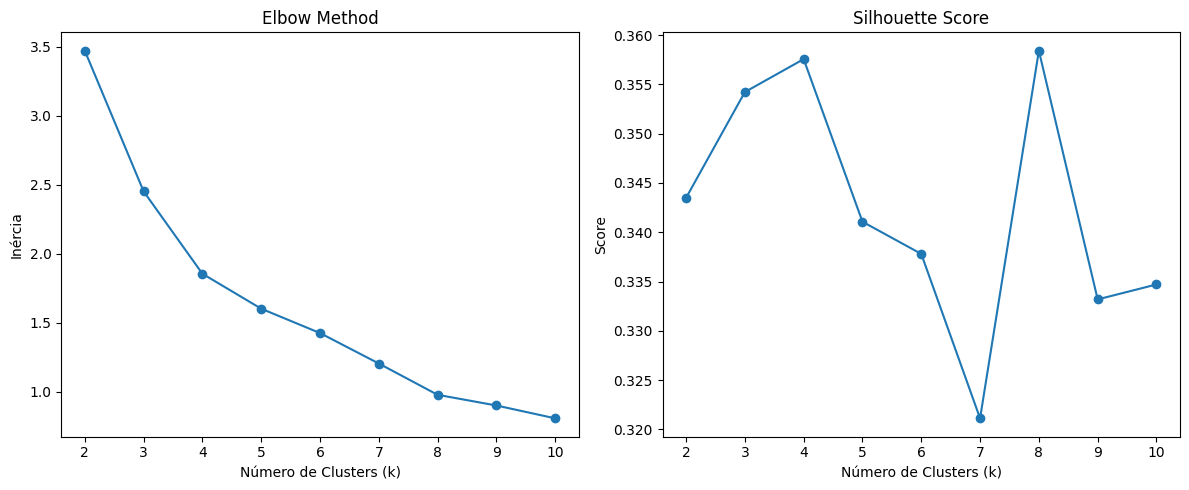

Melhor k com base no Silhouette Score: 8


In [21]:
def elbow_and_silhouette(coords, k_max=10):
    inertias = []
    silhouettes = []

    for k in range(2, k_max + 1):  # começa em 2 porque silhouette não está definido para k=1
        
        # Aplicar KMeans e calcular inércia e silhouette score
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(coords)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(coords, labels))

    # Gráfico do Elbow Method
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, k_max + 1), inertias, marker='o')
    plt.title("Elbow Method")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inércia")

    # Gráfico do Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, k_max + 1), silhouettes, marker='o')
    plt.title("Silhouette Score")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()

    # Encontrar o melhor k com base no maior Silhouette Score
    best_k = np.argmax(silhouettes) + 2  # +2 porque começámos em k=2
    print(f"Melhor k com base no Silhouette Score: {best_k}")
    return best_k

X = df_final[["passing_lane_score", "PLR"]]
optimal_k = elbow_and_silhouette(X, k_max=10)


A partir da análise combinada do **Elbow Method** e do **Silhouette Score**, conclui-se que o número ideal de clusters é \( k = 4 \). No primeiro gráfico (Elbow Method), verifica-se uma mudança acentuada no declive da curva entre \( k = 4 \) e \( k = 5 \), sugerindo que estes valores marcam o ponto a partir do qual o ganho em compactação dos clusters se torna marginal ("Cotovelo"). Já no segundo gráfico (Silhouette Score), embora o valor máximo ocorra em \( k = 8 \), o valor obtido para \( k = 4 \) é bastante próximo desse pico, o que indica que os grupos formados com quatro clusters mantêm uma boa separação e coerência interna.

Com isto, e baseado na análise conjunta dos dois métodos, conclui-se que \( k = 4 \) é a escolha mais acertada, por representar um compromisso sólido entre a qualidade da segmentação e a simplicidade interpretativa dos perfis resultantes.

## Aplicação de Algoritmo de Agrupamento

Após a definição do número ótimo de clusters, procede-se agora à aplicação do algoritmo **K-Means** para segmentar os jogadores com base nas métricas calculadas. Esta etapa permite identificar grupos de jogadores com perfis semelhantes, servindo como base para a análise tática e a interpretação dos diferentes tipos de contributo observados em campo.

Silhouette Score com k=4: 0.358


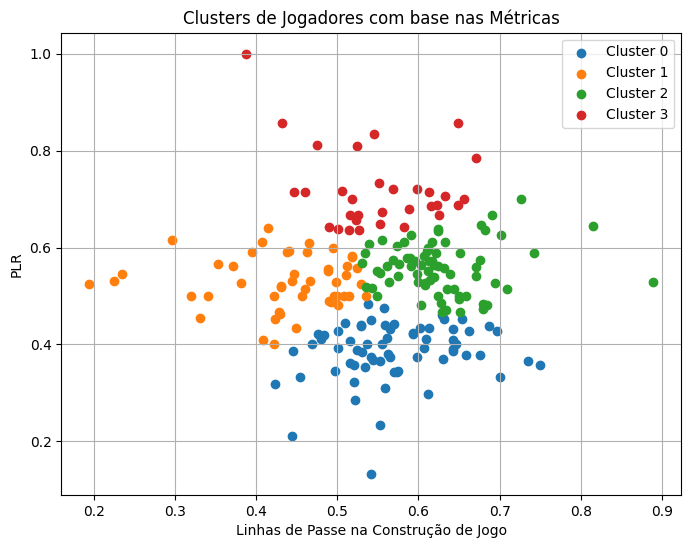

In [22]:
X = df_final[["passing_lane_score", "PLR"]]

# Número de Klustes
optimal_k = 4

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_final["cluster"] = kmeans.fit_predict(X)

# Calcular o Silhouette Score
score = silhouette_score(X, df_final["cluster"])
print(f"Silhouette Score com k={optimal_k}: {score:.3f}")

# Visualizar os clusters
plt.figure(figsize=(8, 6))
for cluster_id in range(optimal_k):
    cluster_data = df_final[df_final["cluster"] == cluster_id]
    plt.scatter(cluster_data["passing_lane_score"], cluster_data["PLR"], label=f"Cluster {cluster_id}")

plt.xlabel("Linhas de Passe na Construção de Jogo")
plt.ylabel("PLR")
plt.title("Clusters de Jogadores com base nas Métricas")
plt.legend()
plt.grid(True)
plt.show()


O Silhouette Score obtido foi de 0.358, um valor que, embora não elevado, é considerado razoável no contexto de dados reais com baixa dimensionalidade — especialmente tendo em conta que a segmentação foi realizada com base em apenas duas variáveis.

Apesar da segmentação apresentar alguma **sobreposição entre clusters**, especialmente na região central do gráfico, os grupos formados demonstram uma estrutura clara e coerente. Esta limitação de separação é justificada pela **restrição dimensional** da análise — a utilização de apenas duas métricas, embora fundamentada no enunciado, reduz a capacidade de capturar nuances mais complexas do comportamento dos jogadores. Ainda assim, os resultados obtidos são **estatisticamente válidos** e **taticamente interpretáveis**.

## Caracterização e Interpretação dos Perfis

A análise dos quatro clusters permite identificar **perfis distintos de jogadores** com base na sua contribuição ofensiva (capacidade de oferecer linhas de passe) e defensiva (eficácia na recuperação após pressão):

- **Cluster 0 (Azul):**  
  Jogadores com **baixo índice de eficácia na recuperação pós-pressão** e **valores medianos na criação de linhas de passe**.  
  Podem representar jogadores com menor envolvimento na recuperação imediata da posse, mas com capacidade variável para se disponibilizar em zonas ofensivas.  
  *Perfil possível:* Jogadores cujas ações pressionantes não resultam em recuperação imediata, mas que mantêm alguma presença na construção ofensiva. Podem corresponder a extremos que mantêm posições mais fixas junto à linha lateral — com menor presença entre linhas - ou médios com menor responsabilidade defensiva e com um papel influente na construção de jogo.

- **Cluster 1 (Laranja):**  
  Jogadores com **PLR intermédio**, mas com **baixa criação de linhas de passe**. 
  Representam um perfil **equilibrado**, com contributo tático regular.  
  *Perfil possível:* atletas que não se destacam ofensivamente no apoio ao portador, mas com impacto relevante na recuperação de bola. Podem ser médios defensivos e de cobertura ou laterais com função mais defensiva, que não se envolvem tanto na fase de construção.

- **Cluster 2 (Verde):**  
  Jogadores com **PLR intermédio**, mas **elevada capacidade para oferecer linhas de passe** durante a construção.   
  Combinam inteligência posicional ofensiva com alguma eficácia defensiva.  
  *Perfil possível:* jogadores com elevada inteligência posicional e envolvimento ofensivo, frequentemente disponíveis como opção de passe em zonas úteis. Este perfil pode encaixar em médios ofensivos, ou extremos interiores que participam ativamente na circulação ofensiva, e que assumem um papel importante na pressão alta da equipa.

- **Cluster 3 (Vermelho):**  
  Jogadores com **grande eficácia na recuperação imediata da posse** e **valores medianos na criação de linhas de passe**.  
  Demonstram elevado impacto na pressão defensiva, com menor ênfase no envolvimento ofensivo.  
  *Perfil possível:* atletas com forte impacto na pressão, com ações defensivas que frequentemente levam à recuperação da bola, mas com menor protagonismo na construção. Este perfil pode corresponder a médios defensivos ou avançados com uma grande capacidade de pressão alta.

A criação destes perfis oferece um suporte objetivo à **análise do desempenho tático individual**. Permite identificar padrões e complementar a avaliação qualitativa tradicional. Apesar de limitada a duas métricas, esta abordagem pode ser expandida no futuro com mais variáveis, de modo a oferecer maior robustez e granularidade aos perfis gerados.